In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV  # Correct import for RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV

In [ ]:


# Load the data files
train_df = pd.read_csv(r"D:\UTS ASSIGNMENTS\Semester 3\AMLA\uts-36120-2024-spr\train.csv", low_memory=False)
test_df = pd.read_csv(r"D:\UTS ASSIGNMENTS\Semester 3\AMLA\uts-36120-2024-spr\test.csv", low_memory=False)
sample_submission_df = pd.read_csv(r"D:\UTS ASSIGNMENTS\Semester 3\AMLA\uts-36120-2024-spr\sample_submission.csv")


In [ ]:
# Define a data cleaning function
def data_cleaning(nba_df):
    # Separate numeric and non-numeric columns
    numeric_cols = nba_df.select_dtypes(include=['number']).columns
    object_cols = nba_df.select_dtypes(include=['object']).columns

    # Fill missing values for numeric columns using median
    nba_df[numeric_cols] = nba_df[numeric_cols].fillna(nba_df[numeric_cols].median())

    # Convert categorical columns to numeric codes
    for col in object_cols:
        nba_df[col] = nba_df[col].astype('category').cat.codes

    return nba_df

# Clean the train and test datasets
train_df_cleaned = data_cleaning(train_df)
test_df_cleaned = data_cleaning(test_df)


In [ ]:
# Define features (X) and target (y)
X = train_df_cleaned.drop(columns=['drafted'])
y = train_df_cleaned['drafted'].astype(int)

# Prepare test features
X_test = test_df_cleaned


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
Best ROC AUC Score: 0.9897870612476819


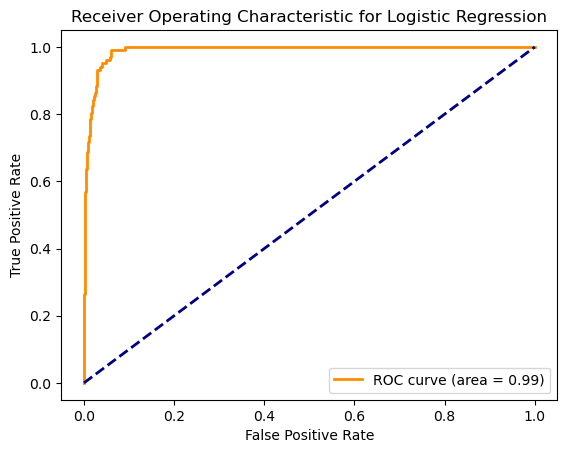

Submission file 'logistic_regression_submission.csv' created successfully!


In [ ]:


# Load the data files
train_df = pd.read_csv(r"D:\UTS ASSIGNMENTS\Semester 3\AMLA\uts-36120-2024-spr\train.csv", low_memory=False)
test_df = pd.read_csv(r"D:\UTS ASSIGNMENTS\Semester 3\AMLA\uts-36120-2024-spr\test.csv", low_memory=False)

# Data Cleaning Function
def data_cleaning(nba_df):
    numeric_cols = nba_df.select_dtypes(include=['number']).columns
    object_cols = nba_df.select_dtypes(include=['object']).columns

    # Fill missing values for numeric columns with median
    nba_df[numeric_cols] = nba_df[numeric_cols].fillna(nba_df[numeric_cols].median())

    # Convert categorical columns to numeric codes
    nba_df[object_cols] = nba_df[object_cols].astype('category').apply(lambda x: x.cat.codes)

    return nba_df

# Clean the datasets
train_df_cleaned = data_cleaning(train_df)
test_df_cleaned = data_cleaning(test_df)

# Define features (X) and target (y) for training
X = train_df_cleaned.drop(columns=['drafted'])
y = train_df_cleaned['drafted'].astype(int)

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numeric features and apply one-hot encoding to categorical features using ColumnTransformer
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['int8']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define the Logistic Regression model with pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['liblinear', 'lbfgs']  # Solvers for logistic regression
}

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and AUC score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)

# Predict probabilities on the validation set
val_probs = grid_search.best_estimator_.predict_proba(X_val)[:, 1]

# Evaluate using ROC curve
fpr, tpr, _ = roc_curve(y_val, val_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

# Prepare the test set and make predictions
X_test = test_df_cleaned.drop(columns=['player_id'])  # Drop non-feature columns

# Predict probabilities on the test set using the best model
test_probs = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Save the submission file
submission_df = pd.DataFrame({'player_id': test_df['player_id'], 'drafted': test_probs})
submission_df.to_csv(r"D:\UTS ASSIGNMENTS\Semester 3\AMLA\uts-36120-2024-spr\logistic_regression_submission.csv", index=False)

print("Submission file 'logistic_regression_submission.csv' created successfully!")
